In [1]:
from skimage import io,img_as_float
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Hauptkomponentenanalyse von Bildern
Die Hauptkomponentenanalyse (Principal Components Analysis, PCA) kann auch auf Bilder angewendet werden. Wie bei anderen Daten sucht die Hauptkomponentenanalyse jene Richtungen (Hauptkomponenten) im hochdimensionalen Bildraum, in welcher die Daten am meisten variieren. Dies sind nützliche Features, wie wir gleich sehen werden.
Die PCA erstellt also Features nicht aus einem einzigen Bild, sondern aus dem ganzen Set von Bildern.

Das folgende Notebook zeigt, wie mit scikit-learn aus Bildern die Hauptkompoonenten extrahiert werden können.

In [2]:
#Wir laden Bilddaten aus unserer Kreuz-Kreis-Plus-Kaggle-Competition 
#(eine .csv-Datei mit 225 Pixelwerten für jedes Bild):
import pandas as pd
df = pd.read_csv('data/KreuzKreisPlus_train.csv',index_col=0)
df.head()

,Dateiname,pix0,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,...,pix216,pix217,pix218,pix219,pix220,pix221,pix222,pix223,pix224,target
0,Bilder/train/0000-u012.png,0,0,0,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,2
1,Bilder/train/0001-u010.png,0,0,0,0,0,0,1,1,1,...,1,1,1,0,0,0,0,0,0,1
2,Bilder/train/0002-u025.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bilder/train/0003-u017.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bilder/train/0004-u008.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [3]:
X = df.iloc[:,1:-1].values
y = df.iloc[:,-1].values

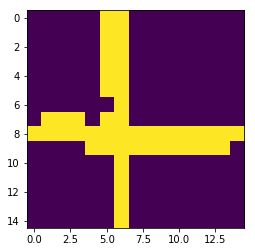

In [4]:
plt.imshow(X[0,:].reshape(15,15));

## PCA anwenden

Die Daten müssen normiert werden! Entweder mit der PCA-Option whiten=True, oder via

In [5]:
from sklearn.preprocessing import scale
Xnorm=scale(X,axis=1)
np.all(np.mean(Xnorm,axis=1)<10**-10)

/media/lws_data/beat/Envs/v_py3/lib/python3.5/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


True

In [6]:
from sklearn.decomposition import PCA
trf= PCA(n_components=3,whiten=True)
trf.fit(X)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [7]:
comp = trf.components_
comp_img=comp.reshape(-1,15,15)

## Eigenfaces betrachten
Die Hauptkomponenten sind nun Vektoren der Länge 225, und können wieder als Bilder (sog. Eigenfaces) dargestellt werden.

In [8]:
def remove_ticks(x=True,y=True):
    if x: plt.gca().axes.get_xaxis().set_visible(False)
    if y: plt.gca().axes.get_yaxis().set_visible(False)
        
def compare_images(imglist,figsize=(15,15),**kwargs):
    """
    Erstelle aus einer Liste von Pixel-Arrays eine Visualisierung 
    der dazugehörigen Bilder, für den praktischen visuellen Vergleich.
    """
    nImages=len(imglist)
    plt.figure(figsize=figsize)
    for i,image in enumerate(imglist):
        plt.subplot(1,nImages,i+1)
        plt.imshow(image,**kwargs);remove_ticks()

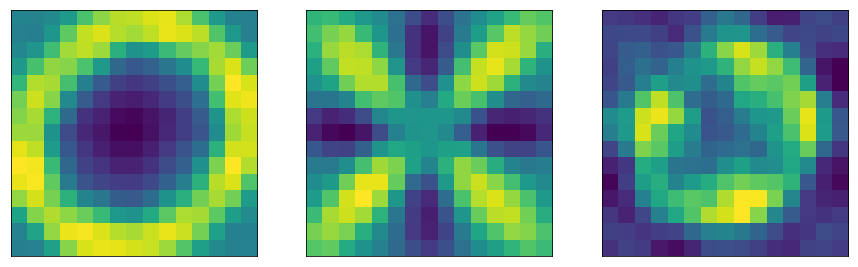

In [9]:
compare_images(comp_img,interpolation='none')

Diese drei Bilder sind die ersten drei Hauptkomponenten und heissen auch Eigenfaces. Sie zeigen eindrücklich die Stärke der PCA und geben Einblick in das, was passiert: Offensichtlich wurde eine Struktur erkannt. Die ersten drei Eigenfaces zeigen die Richtungen, in welche die Bilder am meisten variieren. Zwar sind dies nicht direkt '+','x' und 'o', sondern Linearkombinationen davon. Aber wenn die Bilder auf diese drei Komponenten projiziert werden, ergeben sich dreikomponentige Vektoren, in welchem sich die ursprünglichen Bilder sehr gut trennen lassen. 

Probieren wir's!

Wir suchen uns erst mal ein Bild eines "+" raus:

In [10]:
from random import randint
X_crosses = X[y==0,:]; X_circles = X[y==1,:]; X_plusses = X[y==2,:]; 
X_plusses.shape

(249, 225)

In [11]:
sample_plus_image = X_plusses[randint(0,X_plusses.shape[0]),:]
image_plus = sample_plus_image.reshape(15,15)
image_plus.shape

(15, 15)

Erstellen wir die Darstellung in der Hauptkomponentenbasis: In dieser bedeutet ein Vektor `[1,-5,111]`, dass das Bild durch `1*comp[0]-5*comp[1]+111*comp[2]` dargestellt werden kann wobei `comp = trf.components_`

In [12]:
image_plus_transformed = trf.transform(image_plus.reshape(1,-1))

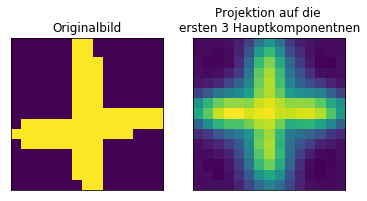

In [13]:
image_plus_projected = trf.inverse_transform(image_plus_transformed)
plt.subplot(1,2,1);plt.imshow(image_plus);plt.title('Originalbild');remove_ticks()
plt.subplot(1,2,2);plt.imshow(image_plus_projected.reshape(15,15));plt.title('Projektion auf die \nersten 3 Hauptkomponentnen');remove_ticks()


In [14]:
np.mean(trf.transform(X_crosses),axis=0)

array([-0.52811323,  1.16441746, -0.07991446])

In [15]:
np.mean(trf.transform(X_circles),axis=0)

array([ 1.11838296, -0.0896018 , -0.01425528])

In [16]:
np.mean(trf.transform(X_plusses),axis=0)

array([-0.57879049, -0.98560632,  0.08706391])

Wir sehen, dass  
  - Kreise v.a. eine grosse (positive) erste Hauptkomponente haben
  - Kreuze v.a. eine grosse (positive) zweite Hauptkomponente haben
  - Plusse v.a. eine grosse (negative) zweite Hauptkomponente haben
  
Diese drei Features enthalten also einen Grossteil aller relevanten Information über die Bilder.

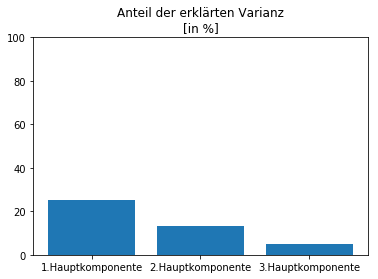

In [17]:
x=[0,1,2]
plt.bar(x,100*trf.explained_variance_ratio_);plt.ylim(0,100)
plt.xticks(x, ('1.Hauptkomponente', '2.Hauptkomponente', '3.Hauptkomponente'))
plt.title('Anteil der erklärten Varianz\n[in %]');